In [30]:
import dynamiqs as dq
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# 2.2

For this task, we produce the Wigner plot for the rotated-displaced frame. We see a lot of fast oscillations, which we assume are there because we are not taking the rotating wave approximation. We Taylor expanded the sine and cosine terms in $H_{ATS}$ to decrease computational time. 

In [31]:
GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

In [32]:
omega_a_0 = 5.26 * GHz # bare resonant frequency of mode a
omega_b_0 = 7.7 * GHz # bare resonant frequency of mode b

phi_a = 0.06 # zero-point fluctuation phase of mode a
phi_b = 0.29 # zero-point fluctuation phase of mode a
e_J = 12.03 * GHz # Josephson energy
delta_e_J = 0.47 * GHz

omega_p = 2.891 * GHz
omega_d = 7.623 * GHz

kappa_a = 9.3 * kHz # relaxation rate of mode a
kappa_b = 2.6 * MHz # relaxation rate of mode b

g2_target = 0.763*MHz # target g2 used to specify driving strength of ATS
alpha_target = np.sqrt(5.0) # target alpha, (or equivalently specify number of photons)

#driving strengths:
eps_p = 2*g2_target/(e_J * phi_a**2 * phi_b) # flux pump power
eps_d = -alpha_target**2 * np.conj(g2_target) # buffer pump power

In [33]:
#Fock-space dimension in the memory mode:
n_fock_a = 20
#Fock-space dimension in the buffer mode:
n_fock_b = 5

#annihilation operators:
a, b = dq.destroy(n_fock_a, n_fock_b)
adag, bdag = a.dag(), b.dag()

#identity operator:
identity = dq.tensor(dq.eye(n_fock_a), dq.eye(n_fock_b))

eps_ats = lambda t: eps_p*jnp.cos(omega_p*t)

In [34]:
#initialization:
delta_a, delta_b = (0.0,0.0) # set initial AC Stark shifts to zero
omega_p = 2*omega_a_0 - omega_b_0 # initial frequency matching condition

#recursion loop to compute AC Stark shift:
rec_depth = 30
for i in range(rec_depth):
    #compute xi for mode a and b:
    alpha_1 = 1j*e_J*eps_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 - omega_p))
    alpha_2 = 1j*e_J*eps_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 + omega_p))

    beta_1 = 1j*e_J*eps_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 - omega_p))
    beta_2 = 1j*e_J*eps_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b
    #compute AC Stark shifts:
    delta_a = 1/3*e_J * eps_p * phi_a**2 * pre 
    delta_b = 1/3*e_J * eps_p * phi_b**2 * pre 

    #recompute frequencies
    omega_a = omega_a_0 - 2*delta_e_J*phi_a**2 + delta_a 
    omega_b = omega_b_0 - 2*delta_e_J*phi_b**2 + delta_b 
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

In [35]:
loss_ops = [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_b) * b]
psi0 = dq.todm(dq.coherent((n_fock_a, n_fock_b), (0.0, 0.0)))

T = 10
t_save = jnp.linspace(0, T, 100)

In [36]:
def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

In [37]:
def hamiltonian_rotating_displaced(t):

    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)


    # the displaced rotating frame introduces a drive and detuning
    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))


    omega_rot_a = omega_a
    omega_rot_b = omega_b
    #compute rotated displaced operators:
    #...
    a_f = op_rot_displaced(t, a, omega_rot_a, alpha_t)
    adag_f = op_rot_displaced(t, a.dag(), omega_rot_a, alpha_t) 
    b_f = op_rot_displaced(t, b, omega_rot_b, beta_t) 
    bdag_f = op_rot_displaced(t, b.dag(), omega_rot_b, beta_t) 

    #displaced rotated phase operator
    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)

    #linear term
    h_0 = omega_a_0 * adag_f @ a_f + omega_b_0 * bdag_f @ b_f
    
    #term from derivative of rotating frame
    h_rot = - omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b
    
    #term from derivative of displaced frame
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))
        

    #ats term:
    sinterm = jnp.sin(eps_ats(t)) * ((phi_f - (1/6)* phi_f @ phi_f @ phi_f))
    costerm = jnp.cos(eps_ats(t)) * (1*identity - (1/2)* phi_f @ phi_f)
    h_ats = - 2*e_J*sinterm +  2*delta_e_J*costerm 
    
    #drive on the buffer:
    # in the rotating frame, this term is non-rotating
    h_buffer_drive = jnp.conj(eps_d)*jnp.exp(1j*omega_d*t)*b_f \
        + eps_d * jnp.exp(-1j*omega_d*t) * bdag_f
    
    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis

In [38]:
H = dq.timecallable(hamiltonian_rotating_displaced)

In [39]:
lop_a = dq.timecallable(lambda t: jnp.sqrt(kappa_a)*op_rot_displaced(t, a, omega_a, alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t))) 
lop_b = dq.timecallable(lambda t: jnp.sqrt(kappa_b)*op_rot_displaced(t, b, omega_b, beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)))                            

In [40]:
res = dq.mesolve(H, [lop_a, lop_b], psi0, t_save)

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|█         |  10.3% ◆ elapsed 569.83ms ◆ remaining 5.42s
|██████████| 100.0% ◆ elapsed 15.30s ◆ remaining 0.00ms  

100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


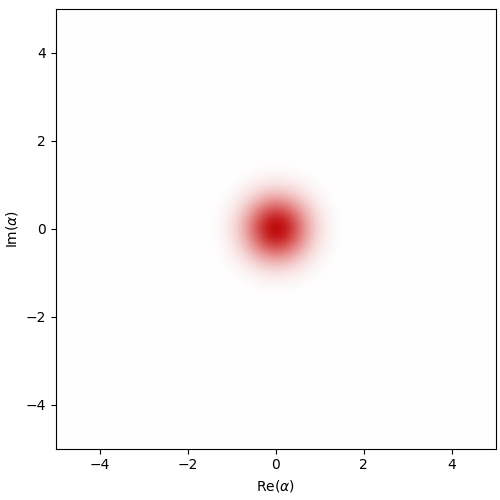

In [21]:
rho_a_rot = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho_a_rot)

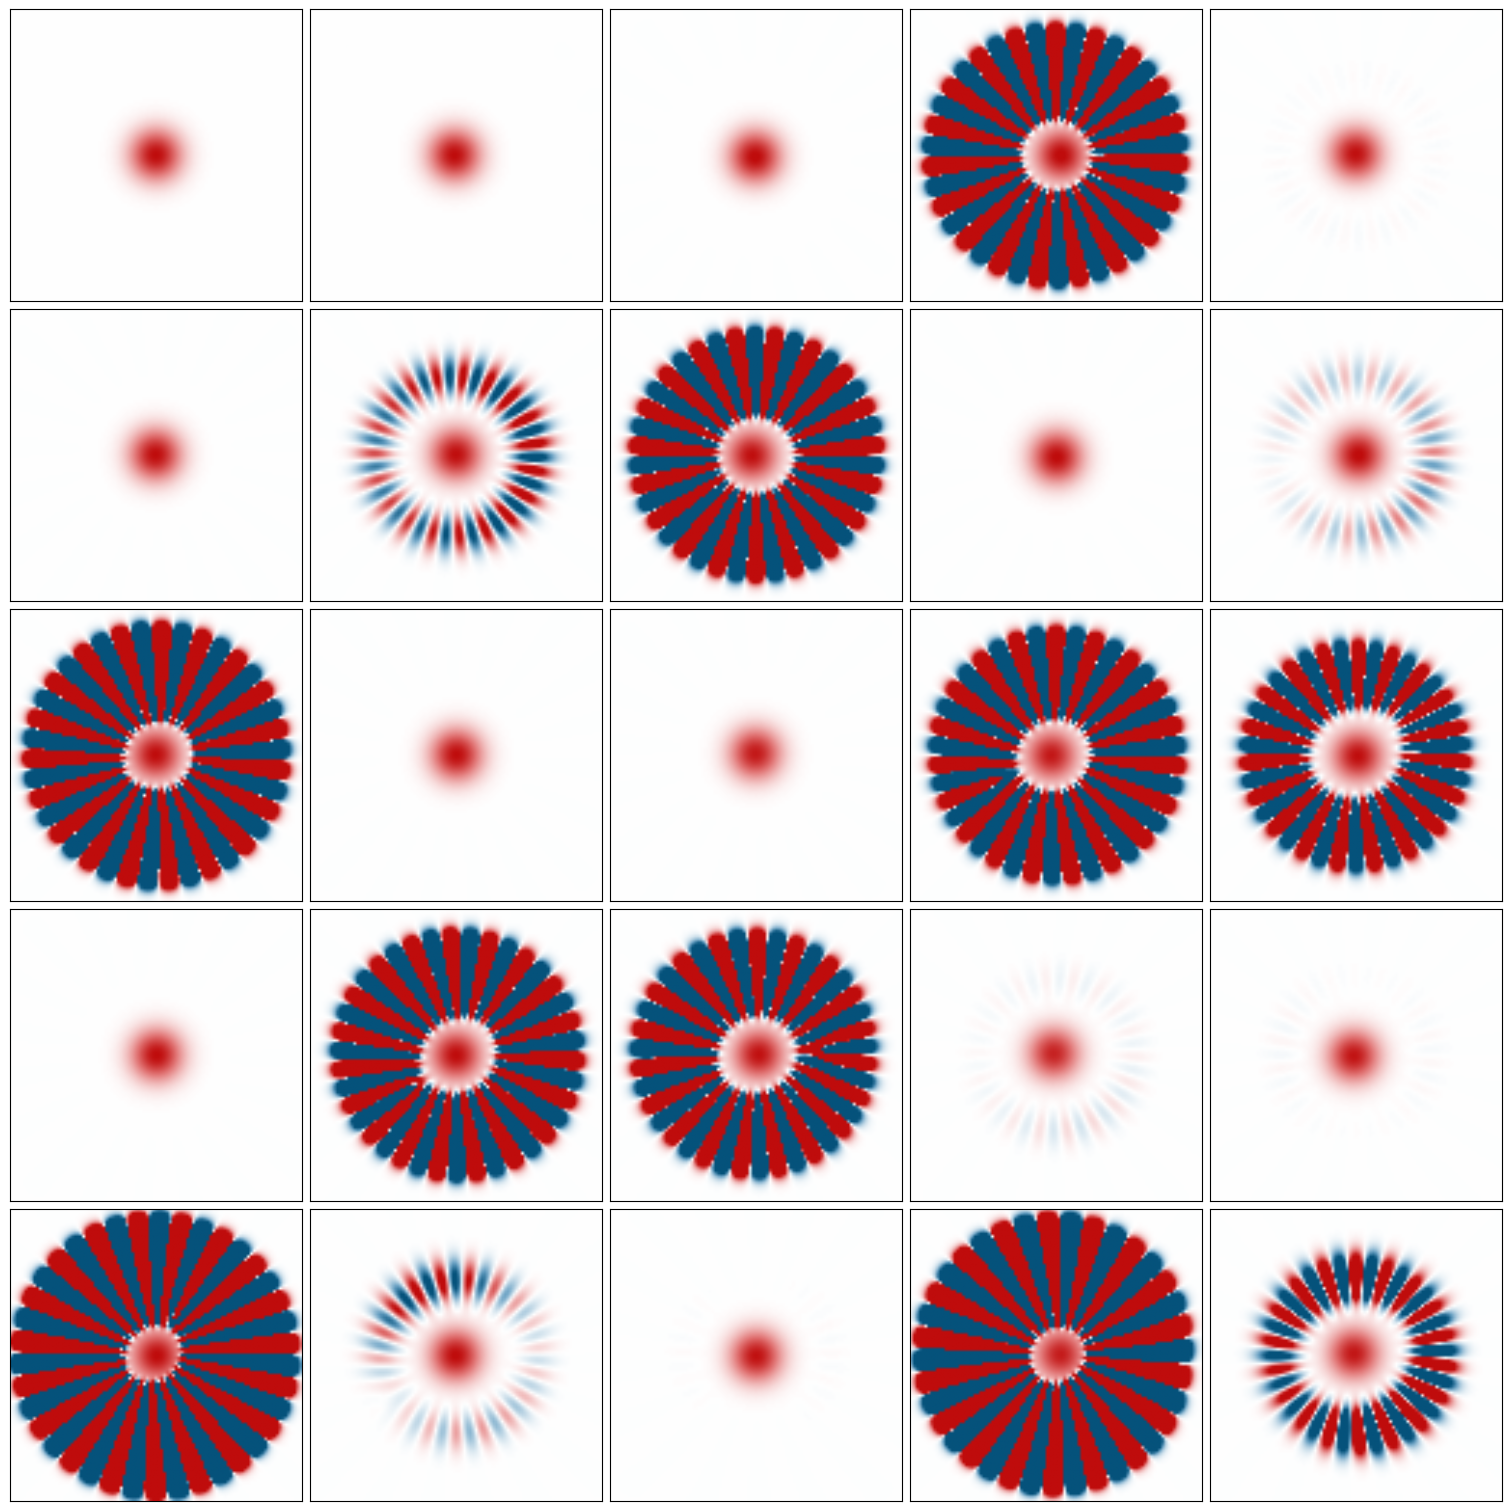

In [22]:
dq.plot.wigner_mosaic(rho_a_rot, n=25, nrows=5, xmax=4.0)

# 2.3

Comparing the state in Task 2.2 with Task 1.1, we find the Fidelity to be very close to 1, although there seems to be some flunctuations around it.

In [23]:
g2 = g2_target
H_2ph = g2 * a.dag() @ a.dag() @ b + jnp.conj(g2) * a @ a @ b.dag()
H = H_2ph 

loss_op = [jnp.sqrt(kappa_b) * b]
res = dq.mesolve(H, loss_op, psi0, t_save)

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|          |   0.1% ◆ elapsed 9.06ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 50.00ms ◆ remaining 0.00ms

100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


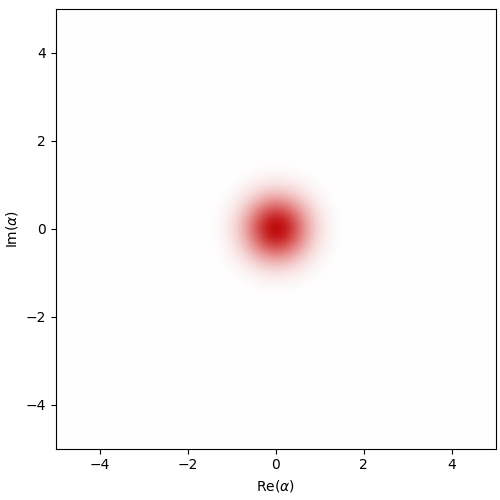

In [24]:
rho_a = dq.ptrace(res.states, 0)
# Then plot Wigner gif of rho_a
dq.plot.wigner_gif(rho_a)

Text(0, 0.5, 'Fidelity')

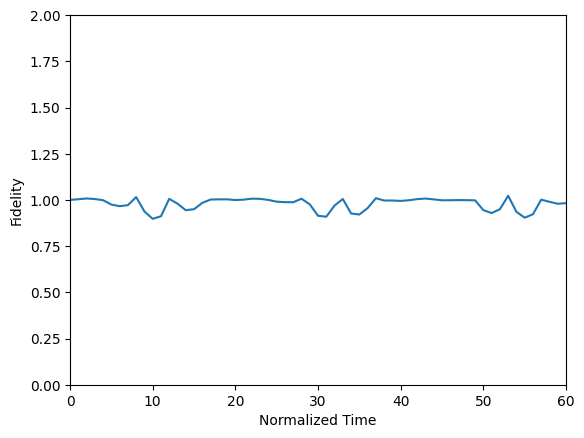

In [25]:
fidelity = dq.fidelity(rho_a, rho_a_rot)  
plt.plot(fidelity)
plt.ylim(0,2)
plt.xlim(0,60)
plt.xlabel("Normalized Time")
plt.ylabel("Fidelity")